In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np
import cupy as cp
import cv2

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

# Model definition

In [3]:
env_x = [-2,10]
env_y = [-1,1]
points_per_unit = 30

width = ((env_x[1] - env_x[0]) * points_per_unit) + 1
height = ((env_y[1] - env_y[0]) * points_per_unit) + 1

env_shape = [height, width]
state_count = width * height
print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: [61, 361]
State count: 22021


In [4]:
# Data loading
ground_data = pd.read_csv('./Data/statistics_abs_ground_3e6.dat', sep=' ', skiprows=[0], names=list(range(320)), index_col=False).to_numpy().T

ground_data = cv2.resize(ground_data, dsize=((4 * points_per_unit) + 1, points_per_unit + 1))

ground_data_padded = np.zeros(env_shape)
ground_data_padded[15:46, 60:181] = ground_data

ground_data = ground_data_padded

In [5]:
# goal state
goal_state_coords = [30,60]
goal_state = (goal_state_coords[0] * env_shape[1]) + goal_state_coords[1]

print(f'Goal state: {goal_state}')

Goal state: 10890


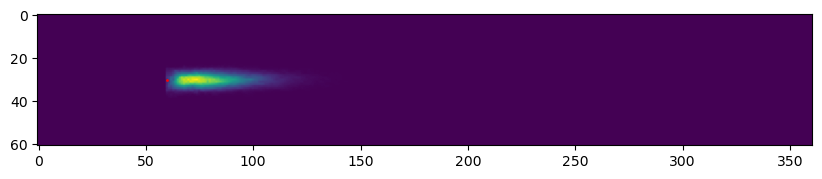

In [6]:
plt.figure(figsize=(10,20))
plt.imshow(ground_data)
plt.scatter(goal_state_coords[1], goal_state_coords[0], c='red',s=1)

In [7]:
# observation matrix
observations = np.empty((state_count, 5, 3)) # 5-actions, 3-observations

# obs 0: Nothing observed, obs 1: Something observed, obs 2: source found

observations[:,:,0] = (1 - ground_data.ravel()[:,None])
observations[:,:,1] = ground_data.ravel()[:,None]

# Detection of goal
observations[:,:,2] = 0.0
observations[goal_state,:,:] = 0.0
observations[goal_state,:,2] = 1.0

In [8]:
# states
state_grid = []

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [9]:
# Reachable states
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 5, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else (state_count - row_w) + s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s - (row_w - 1) # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s % row_w # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s + row_w - 1 # West
    reachable_states[s,4,0] = s # Doesn't move and sniff ground

reachable_states = np.array(reachable_states)

In [10]:
# Reward function
def reward_func(s,a,sn,o):
    return np.where(sn == goal_state, 1.0, 0.0)

In [11]:
# Start belief
start = np.zeros(env_shape)
start[15:46,60:316] = 1.0
start /= np.sum(start)

In [12]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W','O_Ground'],
    observations=['nothing','something','goal'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[goal_state],
    start_probabilities=start.ravel()
)

[11/20/2023, 14:13:52] Instantiation of MDP Model:
[11/20/2023, 14:13:52] - 22021 states
[11/20/2023, 14:13:52] - 5 actions
[11/20/2023, 14:13:52] - At most 1 reachable states per state-action pair
[11/20/2023, 14:13:52] - Starting generation of transitions table
[11/20/2023, 14:13:52]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[11/20/2023, 14:13:52]     > Done in 0.000s
[11/20/2023, 14:13:52] - Generation of state grid
[11/20/2023, 14:13:52] - Generating start probabilities table
[11/20/2023, 14:13:52] - Starting computation of reachable state probabilities from transition data
[11/20/2023, 14:13:52]     > Done in 0.000s

[11/20/2023, 14:13:52] POMDP particular parameters:
[11/20/2023, 14:13:52] - 3 observations
[11/20/2023, 14:13:52] - Starting of transitional observations for reachable states table
[11/20/2023, 14:13:52]     > Done in 0.007s
[11/20/2

In [13]:
# model.save('Alt_Wrap_GroundOnly')

# FSVI Solving

In [14]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [15]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=300,
                                        max_belief_growth=100,
                                        # prune_level=2, # Useless because of belief domination
                                        # prune_interval=25,
                                        # history_tracking_level=2,
                                        use_gpu=True)
print(hist.summary)

[11/20/2023, 11:17:09] Sending Model to GPU...
[11/20/2023, 11:17:10]     > Done in 0.257s
[11/20/2023, 11:17:10] [Warning] MDP solution not provided, running value iteration on the problem to retrieve it...
[11/20/2023, 11:17:10]     > Starting MDP Value Iteration...
[11/20/2023, 11:17:11]     > Value Iteration stopped or converged in 0.903s, and after 918 iteration.



Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Memory full: Out of memory allocating 23,312,311,808 bytes (allocated so far: 64,479,260,160 bytes).
Returning value function and history as is...

Summary of Value Iteration run
  - Model: 22021 state, 5 action, 3 observations
  - Converged or stopped after 300 expansion steps and 299 backup steps.
  - Resulting value function has 8822 alpha vectors.
  - Converged in 206.2083s

  - Expand function took on average 0.0772s and yielded on average 81.59 beliefs per iteration. (0.0009s/it/belief)
  - Backup function took on average 0.6122s and yielded on average value functions of size 3896.14 per iteration. (0.0004s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


In [16]:
# fsvi_solution.save(file_name='20231117_fsvi_g0.99_i300_e100_value_function_wrap_ground_retry.csv', compress=True)

# Loading fsvi solution

In [74]:
# fsvi_solution = ValueFunction.load_from_file('./ValueFunctions/20231117_fsvi_g0.99_i300_e100_value_function_wrap_ground.csv.gzip', model).to_gpu()
fsvi_solution = ValueFunction.load_from_file('./ValueFunctions/20231117_fsvi_g0.99_i300_e100_value_function_wrap_ground_retry.csv.gzip', model).to_gpu()

[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


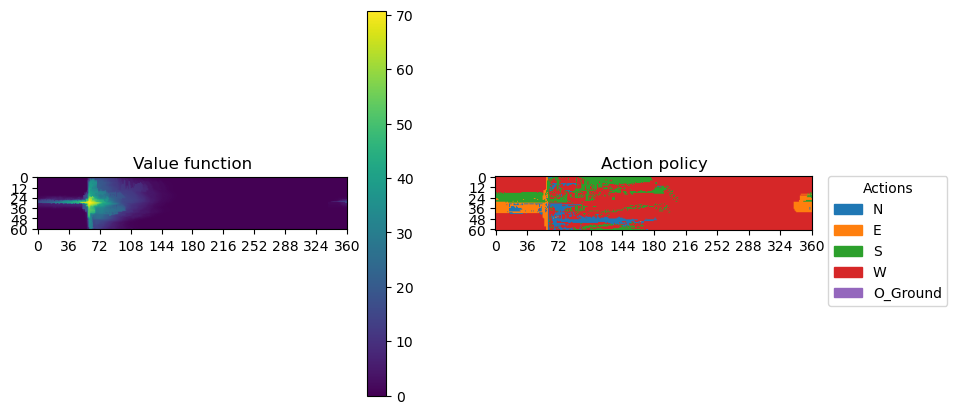

In [27]:
fsvi_solution.plot()

# Sim

In [15]:
a = Agent(model=model, value_function=fsvi_solution)

In [28]:
# a = Agent(model=model, value_function=fsvi_solution.to_cpu())

In [16]:
sim_hist = a.simulate(start_state=(env_shape[1]*15)+300)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 1.240937
	- Steps: 434
	- Total rewards: 1.0
	- End state: s_30_60


In [35]:
sim_hist.save()

[Warning] Beliefs not saved with simulation history but the belief sequence can be recreated from the actions and observations.


In [17]:
sim_hist.save_simulation_video()

Video saved at './Sim Videos/s22021-a5-20231120_140007.mp4'...


# Sim plot

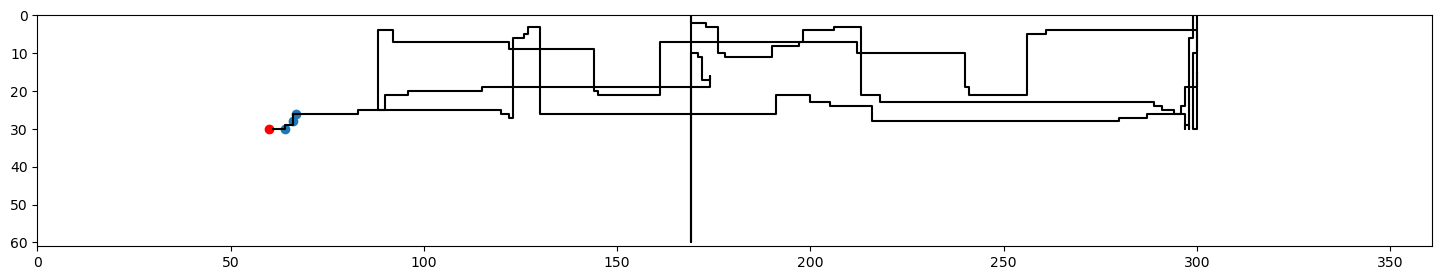

In [33]:
# PLot setup
plt.figure(figsize=(18,3))
plt.xlim(0, env_shape[1])
plt.ylim(env_shape[0], 0)


# Goal
plt.scatter(60, 30, c='red')

# Path
seq = np.array(sim_hist.grid_point_sequence)
plt.plot(seq[:,1], seq[:,0], c='black')

# Something sensed
obs_ts = np.where(np.array(sim_hist.observations) == 1)
points_obs = seq[obs_ts[0],:]
plt.scatter(points_obs[:,1], points_obs[:,0])

# Points sniff
sniff_in_air = np.where(np.array(sim_hist.actions) == 5)
points_sniff = seq[sniff_in_air[0],:]
plt.scatter(points_sniff[:,1], points_sniff[:,0], marker='x')

plt.show()

# Entropy-value plot

In [27]:
from scipy.stats import entropy

In [28]:
ents = [entropy(b.values) for b in sim_hist.beliefs]

In [29]:
b_array = cp.array([(b.values) for b in sim_hist.beliefs])
b_vals = cp.asnumpy(cp.max(cp.matmul(fsvi_solution.alpha_vector_array, b_array.T), axis=0))

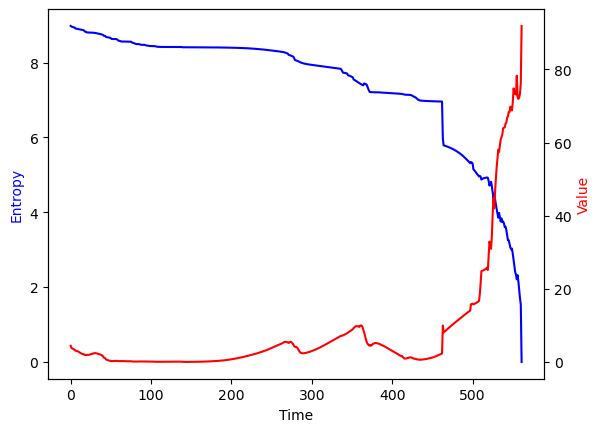

In [65]:
def plot_d(ax):
    ax.set_xlabel('Time')

    # Entropy
    ax.plot(np.arange(len(ents)), ents, color='blue')
    ax.set_ylabel('Entropy', color='blue')

    ax2 = ax.twinx()

    # Value
    ax2.plot(np.arange(len(b_vals)), b_vals, color='red')
    ax2.set_ylabel('Value', color='red')

fig, ax1 = plt.subplots()
plot_d(ax1)
plt.show()

# Multiple simulations

In [15]:
a = Agent(model, fsvi_solution)

In [16]:
# On center line
_, sim_set = a.run_n_simulations_parallel(n=300, start_state=[(env_shape[1]*30)+300, # Center
                                                              (env_shape[1]*15)+300, # Bellow
                                                              (env_shape[1]*45)+300]) # Above

  0%|          | 0/1000 [00:00<?, ?it/s]

All 300 simulations done in 36.331s:
	- Simulations reached goal: 214/300 (86 failures)
	- Average step count: 535.75
	- Average total rewards: 0.7133333333333334
	- Average discounted rewards (ADR): 0.02223882608860371


# Res df

In [26]:
res_df = pd.DataFrame()

# Extra steps needed

In [27]:
sim_lengths = [len(sim) for sim in sim_set]

In [28]:
opt_traj = np.ones(300) * 240
opt_traj[100:] += 15

In [29]:
res_df['Steps'] = sim_lengths
res_df['Extra Steps'] = np.array(sim_lengths) - opt_traj

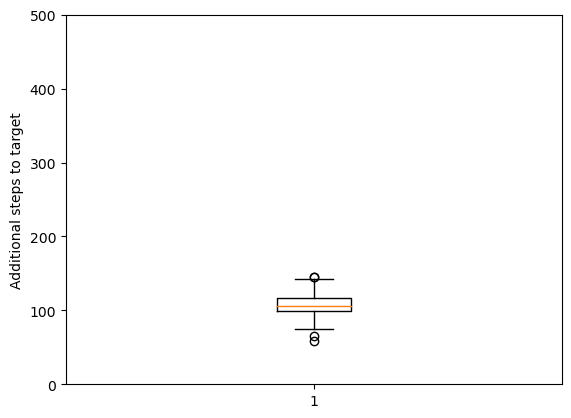

In [33]:
def plot_b(ax):
    ax.set_ylabel('Additional steps to target')
    ax.set_ylim(0,500)
    ax.boxplot(np.array(sim_lengths) - opt_traj)

fig, ax1 = plt.subplots()
plot_b(ax1)
plt.show()

# Save res

In [31]:
# res_df.to_csv('./Results/res_300it_alt_paper_wrap_ground_only.csv', index=False)

# Making sim all accross the space

In [19]:
goal_state_coords

[30, 60]

In [75]:
random_points = []
cell_centers = []

CELL_SIZE = 10
POINT_PER_CELL = 10

height_count = 0

for i in range(15,45,CELL_SIZE):
    height_count += 1
    for j in range(60,300,CELL_SIZE):
        for k in range(POINT_PER_CELL):
            rand_x = np.random.randint(j,j+10)
            rand_y = np.random.randint(i,i+10)

            random_points.append([rand_x, rand_y])

            cell_centers.append([j+(CELL_SIZE/2), i+(CELL_SIZE/2)])

rand_points_array = np.array(random_points)

points_df = pd.DataFrame(rand_points_array, columns=['x','y'])

# Cells
points_df['cell'] = np.repeat(np.arange(len(points_df)/POINT_PER_CELL, dtype=int), POINT_PER_CELL)
cell_centers_array = np.array(cell_centers)
points_df['cell_x'] = cell_centers_array[:,0]
points_df['cell_y'] = cell_centers_array[:,1]

# Traj and ids
points_df['opt_traj'] = np.abs(goal_state_coords[1] - rand_points_array[:,0]) + np.abs(goal_state_coords[0] - rand_points_array[:,1])
points_df['point_id'] = (env_shape[1] * rand_points_array[:,1]) + rand_points_array[:,0]
points_df

,x,y,cell,cell_x,cell_y,opt_traj,point_id
0,65,24,0,65.0,20.0,11,8729
1,66,17,0,65.0,20.0,19,6203
2,61,15,0,65.0,20.0,16,5476
3,64,24,0,65.0,20.0,10,8728
4,64,19,0,65.0,20.0,15,6923
...,...,...,...,...,...,...,...
715,298,36,71,295.0,40.0,244,13294
716,290,44,71,295.0,40.0,244,16174
717,299,43,71,295.0,40.0,252,15822
718,293,42,71,295.0,40.0,245,15455


In [76]:
a = Agent(model, fsvi_solution)
_, all_sim_hist = a.run_n_simulations_parallel(len(rand_points_array), start_state=points_df['point_id'].to_list())

  0%|          | 0/1000 [00:00<?, ?it/s]

All 720 simulations done in 79.962s:
	- Simulations reached goal: 707/720 (13 failures)
	- Average step count: 277.2111111111111
	- Average total rewards: 0.9819444444444444
	- Average discounted rewards (ADR): 0.1818437884721819


In [77]:
# Adding sim results
points_df['steps_taken'] = [len(sim) for sim in all_sim_hist]
points_df['extra_steps'] = points_df['steps_taken'] - points_df['opt_traj']

points_df

,x,y,cell,cell_x,cell_y,opt_traj,point_id,steps_taken,extra_steps
0,65,24,0,65.0,20.0,11,8729,754,743
1,66,17,0,65.0,20.0,19,6203,742,723
2,61,15,0,65.0,20.0,16,5476,787,771
3,64,24,0,65.0,20.0,10,8728,737,727
4,64,19,0,65.0,20.0,15,6923,724,709
...,...,...,...,...,...,...,...,...,...
715,298,36,71,295.0,40.0,244,13294,367,123
716,290,44,71,295.0,40.0,244,16174,339,95
717,299,43,71,295.0,40.0,252,15822,363,111
718,293,42,71,295.0,40.0,245,15455,340,95


In [79]:
# Computing averages per cell
average_per_cell = points_df.groupby('cell').mean('extra_steps')['extra_steps'].to_list()

average_grid = []
item = 0
for i in range(15,45,CELL_SIZE):
    row = []
    for j in range(60,300,CELL_SIZE):
        row.append(average_per_cell[item])
        item += 1
    average_grid.append(row)

average_grid_array = np.array(average_grid)

/tmp/ipykernel_2660847/3135967870.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(average_grid_array, cmap=plt.cm.get_cmap('RdYlGn').reversed())


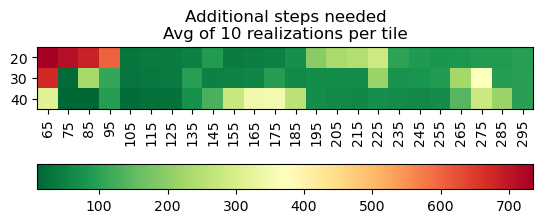

In [82]:
plt.title('Additional steps needed\nAvg of 10 realizations per tile')

plt.imshow(average_grid_array, cmap=plt.cm.get_cmap('RdYlGn').reversed())
plt.colorbar(orientation='horizontal')

# Axes
plt.xticks(np.arange(average_grid_array.shape[1]), labels=np.unique(cell_centers_array[:,0]), rotation=90)
plt.yticks(np.arange(average_grid_array.shape[0]), labels=np.unique(cell_centers_array[:,1]))

plt.show()